In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton, brentq
from scipy.interpolate import interp1d, CubicSpline

file_path_0_3 = 'Year0-3.xlsx'
file_path_3_10 = 'Year3-10.xlsx'

# Read all sheets for inspection (if needed)
data_0_3 = pd.read_excel(file_path_0_3, sheet_name=None)
data_3_10 = pd.read_excel(file_path_3_10, sheet_name=None)

# Load the specific sheets into DataFrames
df_0_3 = pd.read_excel(file_path_0_3, sheet_name='0-3Yrs')
df_3_10 = pd.read_excel(file_path_3_10, sheet_name='Sheet1')

# -------------------------------------------------------------------
# 2. Extract Bond Information from Column Names (unchanged)
# -------------------------------------------------------------------
def extract_bond_info(columns):
    """
    Extracts bond details from column names.
    Each bond column (after the Date column) is expected to be in the format:
       "coupon,ISIN,issue_date,maturity_date"
    """
    bond_info = []
    for col in columns[1:]:  # Skip the Date column
        parts = col.split(',')
        if len(parts) == 4:
            coupon, isin, issue_date, maturity_date = parts
            coupon = float(coupon.strip())
            isin = isin.strip()
            issue_date = pd.to_datetime(issue_date.strip())
            maturity_date = pd.to_datetime(maturity_date.strip())
            bond_info.append({
                'Coupon': coupon,
                'ISIN': isin,
                'Issue Date': issue_date,
                'Maturity Date': maturity_date,
                'Label': f"CAN {coupon*100:.2f} {maturity_date.strftime('%b %y')}"
            })
    return pd.DataFrame(bond_info)

# Extract bond info from both datasets
bonds_0_3 = extract_bond_info(df_0_3.columns)
bonds_3_10 = extract_bond_info(df_3_10.columns)

# Combine the two datasets
all_bonds = pd.concat([bonds_0_3, bonds_3_10], ignore_index=True)

# -------------------------------------------------------------------
# 3. Filter Bonds Maturing Within 0-5 Years
# -------------------------------------------------------------------
# Set the evaluation date (for example, January 6, 2025)
eval_date = pd.Timestamp('2025-01-06')
cutoff_date = eval_date + pd.DateOffset(years=5)

# Keep bonds maturing after eval_date and on or before the cutoff date
filtered_bonds = all_bonds[(all_bonds['Maturity Date'] > eval_date) & 
                           (all_bonds['Maturity Date'] <= cutoff_date)].copy()

# Compute time to maturity in years (including fractions) as of eval_date
filtered_bonds['TimeToMaturity'] = (filtered_bonds['Maturity Date'] - eval_date).dt.days / 365.25

# -------------------------------------------------------------------
# 4. Select 10 Bonds Covering the 0-5 Year Range with Similar Coupon Rates
# -------------------------------------------------------------------
# The idea is to use bonds that are consistent – for example, having similar coupon rates –
# so that differences in yield are more clearly driven by maturity.
# First, compute the median coupon rate from the filtered bonds.
median_coupon = filtered_bonds['Coupon'].median()

# Set a tolerance for coupon consistency (for example, within ±0.005, i.e. ±0.5%)
tol = 0.005  
filtered_consistent = filtered_bonds[abs(filtered_bonds['Coupon'] - median_coupon) <= tol]

# If too few bonds are found, broaden the tolerance.
if len(filtered_consistent) < 10:
    print("Not enough bonds within ±0.5% coupon rate of the median; broadening tolerance to ±1.0%.")
    tol = 0.01
    filtered_consistent = filtered_bonds[abs(filtered_bonds['Coupon'] - median_coupon) <= tol]

if len(filtered_consistent) < 10:
    raise ValueError("Not enough bonds with similar coupon rates available for a consistent yield curve.")

# Now select 10 bonds evenly spread over the 0–5 year maturity range from the consistent set.
# Define target maturities from the minimum available time (in filtered_consistent) to 5 years.
target_times = np.linspace(filtered_consistent['TimeToMaturity'].min(), 5, 10)

selected_bonds = []
selected_isins = set()  # to avoid duplicates

for target in target_times:
    candidates = filtered_consistent.copy()
    # Calculate the absolute difference between each bond's time-to-maturity and the target
    candidates['diff'] = (candidates['TimeToMaturity'] - target).abs()
    candidates.sort_values(by='diff', inplace=True)
    
    candidate_chosen = None
    # Pick the candidate that has not been selected yet.
    for _, row in candidates.iterrows():
        if row['ISIN'] not in selected_isins:
            candidate_chosen = row
            break
    if candidate_chosen is not None:
        selected_bonds.append(candidate_chosen)
        selected_isins.add(candidate_chosen['ISIN'])

# If we still have fewer than 10 bonds, fill in with additional bonds (sorted by time-to-maturity).
if len(selected_bonds) < 10:
    remaining = filtered_consistent[~filtered_consistent['ISIN'].isin(selected_isins)].copy()
    remaining.sort_values(by='TimeToMaturity', inplace=True)
    needed = 10 - len(selected_bonds)
    for _, row in remaining.head(needed).iterrows():
        selected_bonds.append(row)
        selected_isins.add(row['ISIN'])

# Ensure exactly 10 bonds are selected.
if len(selected_bonds) > 10:
    selected_bonds = selected_bonds[:10]

# Create a DataFrame for the selected bonds.
selected_bonds_df = pd.DataFrame(selected_bonds).reset_index(drop=True)

# Add a column for the semi-annual coupon payment (for clarity later on)
selected_bonds_df['Semi-Annual Coupon Payment (%)'] = selected_bonds_df['Coupon'] * 50

# Display the selected bonds.
cols_to_show = ['Label', 'Coupon', 'TimeToMaturity', 'Maturity Date', 'Semi-Annual Coupon Payment (%)']
print("Selected Bonds (0-5 years with similar coupon rates):")
print(selected_bonds_df[cols_to_show])







Not enough bonds within ±0.5% coupon rate of the median; broadening tolerance to ±1.0%.
Selected Bonds (0-5 years with similar coupon rates):
             Label  Coupon  TimeToMaturity Maturity Date  \
0  CAN 3.75 Feb 25  0.0375        0.071184    2025-02-01   
1  CAN 3.50 Aug 25  0.0350        0.566735    2025-08-01   
2  CAN 3.00 Apr 26  0.0300        1.232033    2026-04-01   
3  CAN 3.25 Nov 26  0.0325        1.817933    2026-11-01   
4  CAN 3.00 Feb 27  0.0300        2.069815    2027-02-01   
5  CAN 2.75 Sep 27  0.0275        2.650240    2027-09-01   
6  CAN 2.00 Jun 28  0.0200        3.400411    2028-06-01   
7  CAN 3.25 Sep 28  0.0325        3.652293    2028-09-01   
8  CAN 2.25 Jun 29  0.0225        4.399726    2029-06-01   
9  CAN 2.25 Dec 29  0.0225        4.900753    2029-12-01   

   Semi-Annual Coupon Payment (%)  
0                           1.875  
1                           1.750  
2                           1.500  
3                           1.625  
4                

Sample of combined prices:
            CAN 3.75 Feb 25  CAN 3.50 Aug 25  CAN 3.00 Apr 26  \
Date                                                            
2025-01-06           100.03           100.26           100.05   
2025-01-07           100.01           100.25           100.04   
2025-01-08           100.03           100.24           100.04   
2025-01-09           100.02           100.25           100.06   
2025-01-10           100.00           100.19            99.92   

            CAN 3.25 Nov 26  CAN 3.00 Feb 27  CAN 2.75 Sep 27  \
Date                                                            
2025-01-06           100.47           100.11            99.63   
2025-01-07            99.91           100.14            99.56   
2025-01-08           100.42           100.08            99.54   
2025-01-09            99.96           100.10            99.58   
2025-01-10            99.73            99.96            99.27   

            CAN 2.00 Jun 28  CAN 3.25 Sep 28  CAN 2.25 Jun 29

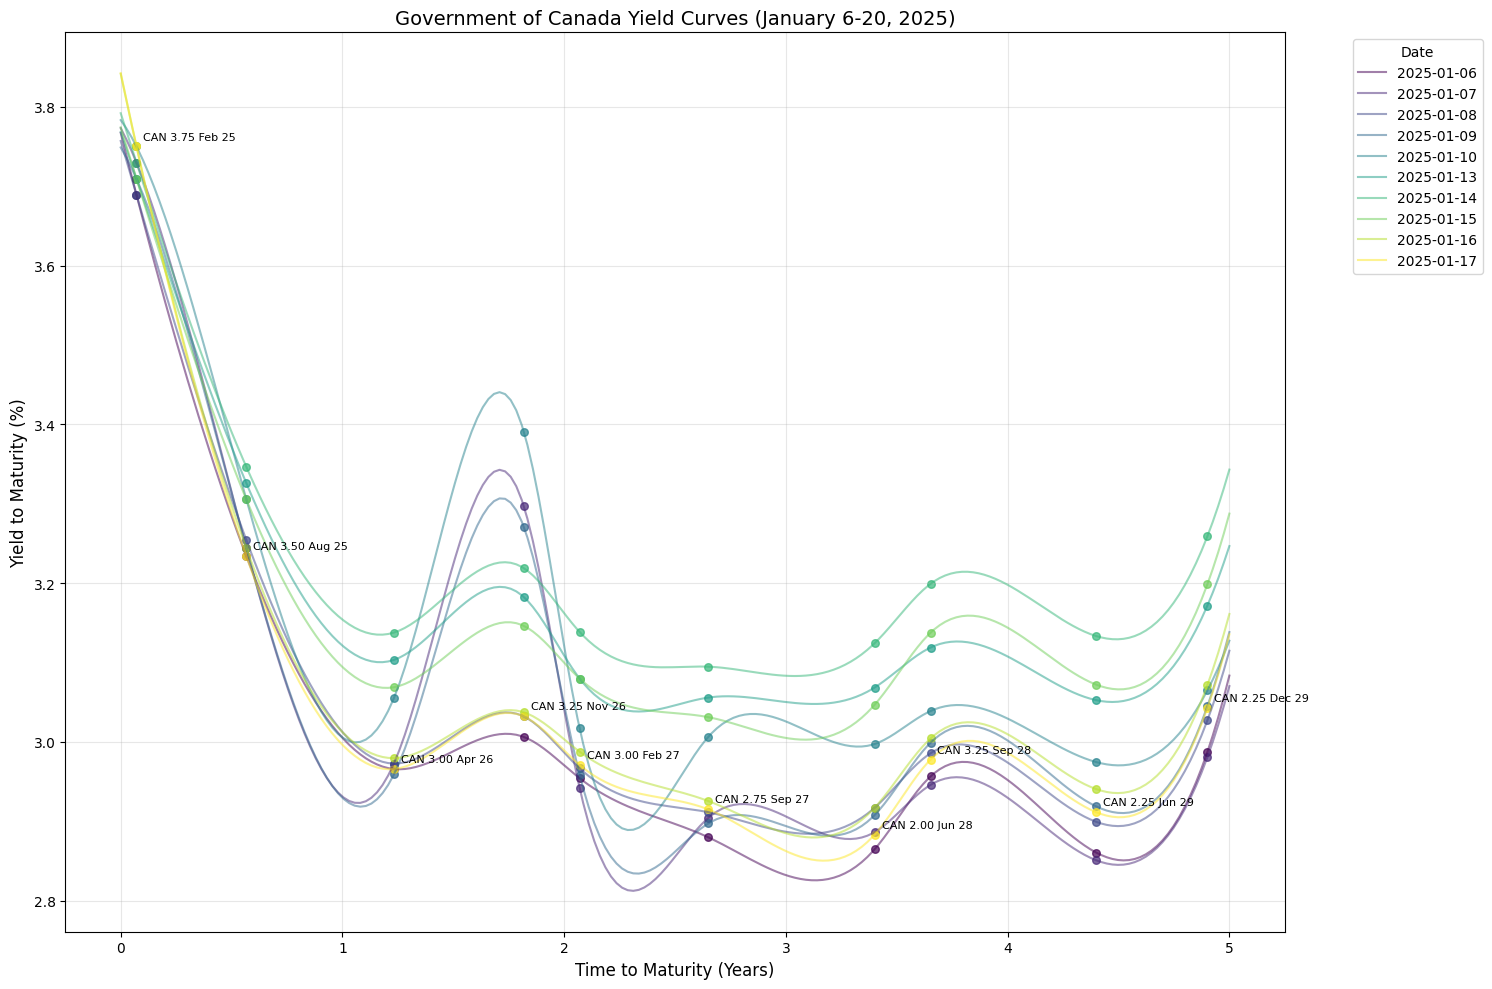


Yields for first date:
CAN 3.75 Feb 25: 3.75%
CAN 3.50 Aug 25: 3.23%
CAN 3.00 Apr 26: 2.97%
CAN 3.25 Nov 26: 3.03%
CAN 3.00 Feb 27: 2.97%
CAN 2.75 Sep 27: 2.91%
CAN 2.00 Jun 28: 2.88%
CAN 3.25 Sep 28: 2.98%
CAN 2.25 Jun 29: 2.91%
CAN 2.25 Dec 29: 3.04%

Covariance Matrix for Spot Rate Changes:
              1             2             3             4             5   \
1   1.140973e-07  1.640332e-09  4.734448e-09  4.923735e-07 -4.940687e-08   
2   1.640332e-09  1.330854e-07  2.064871e-07  1.390628e-07  1.846499e-07   
3   4.734448e-09  2.064871e-07  3.291712e-07  2.018810e-07  2.948700e-07   
4   4.923735e-07  1.390628e-07  2.018810e-07  3.767808e-06 -7.893587e-08   
5  -4.940687e-08  1.846499e-07  2.948700e-07 -7.893587e-08  3.103270e-07   
6   9.230606e-10  2.315379e-07  3.636540e-07  2.507975e-07  3.236982e-07   
7  -3.513570e-08  2.573961e-07  4.024360e-07  1.482144e-07  3.924668e-07   
8  -8.416447e-08  2.142254e-07  3.386698e-07 -4.982558e-08  3.815449e-07   
9  -7.571894e-08  2.

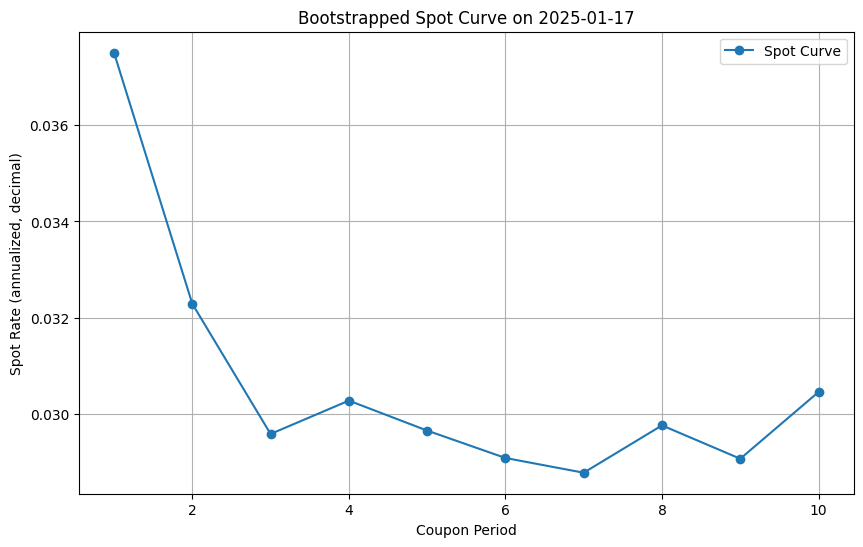

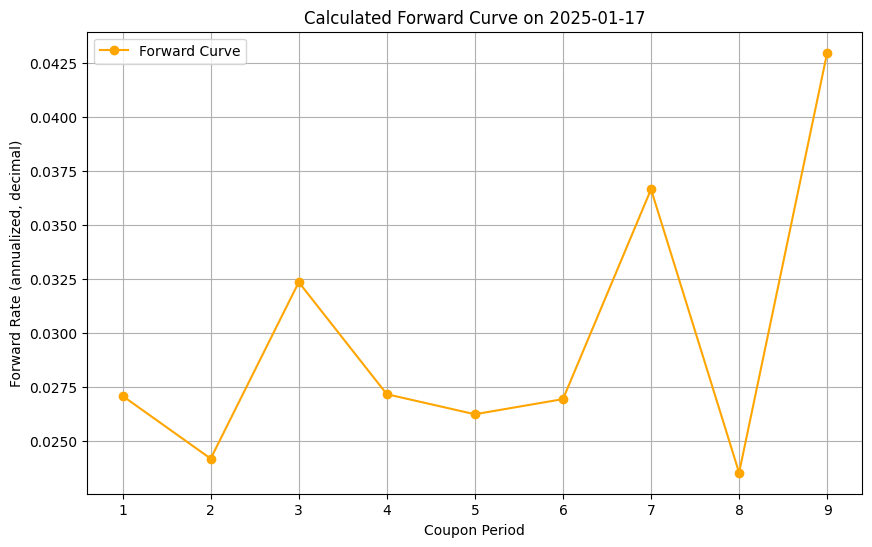

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton, brentq
from scipy.interpolate import CubicSpline, interp1d

#################################
# 1. Build the Combined Daily Price Series for the Selected Bonds
#################################
def get_price_series(isin):
    """
    Given an ISIN, return the daily price series from either df_0_3 or df_3_10.
    Assumes the column header contains the ISIN.
    """
    for col in df_0_3.columns[1:]:
        if isin in col:
            temp = df_0_3[['Date', col]].rename(columns={col: 'Price'})
            temp['Date'] = pd.to_datetime(temp['Date'])
            return temp
    for col in df_3_10.columns[1:]:
        if isin in col:
            temp = df_3_10[['Date', col]].rename(columns={col: 'Price'})
            temp['Date'] = pd.to_datetime(temp['Date'])
            return temp
    return None

price_series_list = []
for idx, row in selected_bonds_df.iterrows():
    isin = row['ISIN']
    label = row['Label']
    ps = get_price_series(isin)
    if ps is not None:
        ps = ps.rename(columns={'Price': label})
        ps.set_index('Date', inplace=True)
        price_series_list.append(ps)
        
if not price_series_list:
    raise ValueError("No price series found for the selected bonds.")

# Merge the daily price series (outer join on Date)
combined_prices = pd.concat(price_series_list, axis=1)
combined_prices.sort_index(inplace=True)
print("Sample of combined prices:")
print(combined_prices.head())

def calculate_bond_price(ytm, face_value, coupon_rate, time_to_maturity):
    """Calculate bond price with semi-annual compounding"""
    periods = int(np.ceil(time_to_maturity * 2))  # Round up for partial periods
    coupon = face_value * coupon_rate / 2  # Semi-annual coupon
    
    price = 0
    for t in range(1, periods + 1):
        if t == periods:
            cash_flow = coupon + face_value
        else:
            cash_flow = coupon
        price += cash_flow / ((1 + ytm/2) ** t)
    return price

def calculate_ytm(price, face_value, coupon_rate, time_to_maturity, tolerance=1e-5):
    """Calculate YTM using Newton's method with better initial guess"""
    def price_difference(y):
        return calculate_bond_price(y, face_value, coupon_rate, time_to_maturity) - price
    
    # Better initial guess based on simple yield calculation
    simple_yield = (coupon_rate * face_value + (face_value - price)/time_to_maturity) / price
    
    try:
        ytm = newton(price_difference, simple_yield, tol=tolerance, maxiter=100)
        return max(0, ytm)  # Prevent negative yields
    except:
        # Fallback to brute force if Newton's method fails
        rates = np.linspace(0, 0.2, 1000)  # 0% to 20%
        prices = [calculate_bond_price(r, face_value, coupon_rate, time_to_maturity) for r in rates]
        idx = np.argmin(np.abs(np.array(prices) - price))
        return rates[idx]

# Test with first bond
price = 100.03  # Example price for CAN 3.75 Feb 25
coupon_rate = 0.0375
time_to_maturity = 0.071184
ytm = calculate_ytm(price, 100, coupon_rate, time_to_maturity)
print(f"Test YTM: {ytm*100:.2f}%")

# Function to calculate YTMs for all bonds
def calculate_all_ytms(bonds_data, prices):
    ytms = []
    for bond in bonds_data:
        ytm = calculate_ytm(
            prices[bond['Label']], 
            100,  # face value
            bond['Coupon'],
            bond['TimeToMaturity']
        )
        ytms.append(ytm * 100)  # Convert to percentage
    return ytms

# Load and process daily prices
price_series_list = []
for idx, row in selected_bonds_df.iterrows():
    label = row['Label']
    price_series = pd.Series(combined_prices[label], name=label)
    price_series_list.append(price_series)

daily_prices = pd.concat(price_series_list, axis=1)

# Calculate YTM for each bond on each date
dates = daily_prices.index
bond_data = selected_bonds_df.to_dict('records')

# Create the plot
plt.figure(figsize=(15, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(dates)))

# Create interpolation points for smooth curves
x_smooth = np.linspace(0, 5, 200)

# Plot yield curve for each date
for date, color in zip(dates, colors):
    prices = daily_prices.loc[date]
    
    # Calculate YTMs for this date
    ttm = np.array([bond['TimeToMaturity'] for bond in bond_data])
    yields = np.array([
        calculate_ytm(prices[bond['Label']], 100, bond['Coupon'], bond['TimeToMaturity'])
        for bond in bond_data if not pd.isna(prices[bond['Label']])
    ]) * 100  # Convert to percentage
    
    # Sort by time to maturity
    sort_idx = np.argsort(ttm)
    ttm = ttm[sort_idx]
    yields = yields[sort_idx]
    
    # Cubic spline interpolation
    if len(ttm) > 2:  # Need at least 3 points for cubic spline
        cs = CubicSpline(ttm, yields)
        y_smooth = cs(x_smooth)
        plt.plot(x_smooth, y_smooth, color=color, alpha=0.5,
                label=date.strftime('%Y-%m-%d'))
    
    plt.scatter(ttm, yields, color=color, alpha=0.7, s=30)

plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Yield to Maturity (%)', fontsize=12)
plt.title('Government of Canada Yield Curves (January 6-20, 2025)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          title='Date', fontsize=10, title_fontsize=10)

# Add bond labels for the first curve
for t, y, bond in zip(ttm, yields, bond_data):
    plt.annotate(bond['Label'],
                (t, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

plt.tight_layout()
plt.show()

# Print yields for verification
print("\nYields for first date:")
for bond, yld in zip(bond_data, yields):
    print(f"{bond['Label']}: {yld:.2f}%")

#################################
# 3. Bootstrapping the Spot Curve and Calculating Forward Rates
#################################
def bootstrap_daily_spot_curve(current_date, bonds_data, face=100):
    """
    For a given day, bootstrap the spot–rate curve from a list of bonds.
    
    bonds_data: list of dictionaries with keys:
         'label'   : Bond identifier,
         'coupon'  : Annual coupon rate (decimal),
         'maturity': pd.Timestamp (maturity date),
         'price'   : Observed price on current_date,
         'n'       : Number of semiannual periods remaining (integer).
         
    Returns a dictionary mapping each coupon period (1,2,...) to a bootstrapped spot rate.
    """
    # Sort bonds by increasing number of coupon periods remaining.
    sorted_bonds = sorted(bonds_data, key=lambda x: x['n'])
    spot_rates = {}  # key: period number, value: list of computed spot rates
    
    for bond in sorted_bonds:
        n = bond['n']
        coupon = bond['coupon']
        price = bond['price']
        if n < 1:
            continue
        if n == 1:
            # For a single period: Price = (coupon*face/2 + face) / (1 + r/2)
            r = 2 * ((coupon * face/2 + face) / price - 1)
            spot_rates.setdefault(n, []).append(r)
        else:
            # Ensure that for all coupon dates prior to the final one, we have bootstrapped spot rates.
            if not all(i in spot_rates for i in range(1, n)):
                continue
            sum_known = 0.0
            for i in range(1, n):
                # Use the average if more than one bond provided a rate for period i.
                r_i = np.mean(spot_rates[i])
                sum_known += (coupon * face/2) / ((1 + r_i/2)**i)
            def f(r):
                return sum_known + (coupon * face/2 + face) / ((1 + r/2)**n) - price
            try:
                r_n = brentq(f, a=-0.1, b=0.5)
                spot_rates.setdefault(n, []).append(r_n)
            except Exception as e:
                # Bootstrapping failed for this bond; skip it.
                continue

    # Average the spot rates for each period
    averaged_spot_rates = {}
    for period, rates in spot_rates.items():
        averaged_spot_rates[period] = np.mean(rates)
    return averaged_spot_rates

def calculate_forward_rates(spot_rates):
    """
    Calculate 1-period forward rates from a bootstrapped spot–rate curve.
    
    spot_rates: dictionary mapping coupon period (1,2,...) to spot rates.
    
    Returns a dictionary mapping period i (from 1 to max-1) to the forward rate 
    (i.e. the rate from the end of period i to period i+1).
    """
    forward_rates = {}
    periods = sorted(spot_rates.keys())
    for i in periods[:-1]:
        s_i = spot_rates[i]
        s_next = spot_rates[i+1]
        # The forward rate f_i satisfies: (1+s_next/2)^(i+1) = (1+s_i/2)^i * (1+f_i/2)
        forward_rate = 2 * (((1+s_next/2)**(i+1) / ((1+s_i/2)**i)) - 1)
        forward_rates[i] = forward_rate
    return forward_rates

#################################
# 4. Loop Over Each Day: Build Bootstrapped Spot & Forward Curves, and Store Them
#################################
# We will loop over the days in the combined prices DataFrame.
# For each day, we use the selected bonds (from selected_bonds_df) that have not yet matured,
# get their daily price, and (assuming semiannual coupons) compute the number of periods remaining.
# Then, we bootstrap a spot curve and calculate forward rates.

daily_spot_curves = {}     # key: date, value: dictionary {period: spot rate}
daily_forward_curves = {}  # key: date, value: dictionary {period: forward rate}
face_value = 100

for current_date in combined_prices.index:
    bonds_list = []
    for idx, bond in selected_bonds_df.iterrows():
        label = bond['Label']
        coupon = bond['Coupon']
        maturity = bond['Maturity Date']
        if current_date >= maturity:
            continue  # skip matured bonds
        try:
            price = combined_prices.loc[current_date, label]
        except KeyError:
            continue
        if pd.isnull(price):
            continue
        # Compute time-to-maturity in years and then the number of semiannual periods.
        ttm_years = (maturity - current_date).days / 365.25
        n_periods = int(np.ceil(ttm_years * 2))
        if n_periods < 1:
            continue
        bonds_list.append({
            'label': label,
            'coupon': coupon,
            'maturity': maturity,
            'price': price,
            'n': n_periods
        })
    if len(bonds_list) >= 1:
        spot_curve = bootstrap_daily_spot_curve(current_date, bonds_list, face=face_value)
        if spot_curve:
            daily_spot_curves[current_date] = spot_curve
            fwd_curve = calculate_forward_rates(spot_curve)
            daily_forward_curves[current_date] = fwd_curve

#################################
# 5. Organize Daily Spot and Forward Curves into DataFrames
#################################
# Determine the maximum period (i.e. longest maturity in semiannual periods) over all days.
if daily_spot_curves:
    max_period_spot = max(max(curve.keys()) for curve in daily_spot_curves.values())
else:
    max_period_spot = 0

# Build a DataFrame for spot rates: rows are dates, columns are period numbers.
spot_df = pd.DataFrame(index=combined_prices.index, columns=range(1, max_period_spot+1))
for date, curve in daily_spot_curves.items():
    for period in range(1, max_period_spot+1):
        spot_df.at[date, period] = curve.get(period, np.nan)
spot_df = spot_df.sort_index()

# Similarly, for forward rates.
if daily_forward_curves:
    max_period_forward = max(max(curve.keys()) for curve in daily_forward_curves.values())
    forward_df = pd.DataFrame(index=combined_prices.index, columns=range(1, max_period_forward+1))
    for date, curve in daily_forward_curves.items():
        for period in range(1, max_period_forward+1):
            forward_df.at[date, period] = curve.get(period, np.nan)
    forward_df = forward_df.sort_index()
else:
    forward_df = pd.DataFrame()

#################################
# 6. Compute Daily Changes, Covariance Matrices, and Perform PCA
#################################
# (Here we focus on the spot curve changes; one could equally use forward rate changes.)

# Compute daily differences (first differences) for spot rates.
spot_diff = spot_df.diff().dropna()

# Calculate the covariance matrix for these daily changes.
cov_spot = spot_diff.cov()
print("\nCovariance Matrix for Spot Rate Changes:")
print(cov_spot)

# Perform a PCA (eigen-decomposition) of the covariance matrix.
eigenvalues, eigenvectors = np.linalg.eig(cov_spot)
print("\nEigenvalues of Spot Rate Changes:")
print(eigenvalues)
print("\nEigenvectors of Spot Rate Changes:")
print(eigenvectors)

#################################
# 7. Plot Sample Curves
#################################
# For illustration, plot the bootstrapped spot and forward curves on a selected day (e.g. the last day available).
if not spot_df.empty:
    sample_date = spot_df.index[-1]
    sample_spot = spot_df.loc[sample_date].dropna()
    periods = sample_spot.index.astype(int)
    plt.figure(figsize=(10, 6))
    plt.plot(periods, sample_spot, marker='o', label='Spot Curve')
    plt.xlabel('Coupon Period')
    plt.ylabel('Spot Rate (annualized, decimal)')
    plt.title(f'Bootstrapped Spot Curve on {sample_date.date()}')
    plt.grid(True)
    plt.legend()
    plt.show()

if not forward_df.empty:
    sample_forward = forward_df.loc[sample_date].dropna()
    periods = sample_forward.index.astype(int)
    plt.figure(figsize=(10, 6))
    plt.plot(periods, sample_forward, marker='o', color='orange', label='Forward Curve')
    plt.xlabel('Coupon Period')
    plt.ylabel('Forward Rate (annualized, decimal)')
    plt.title(f'Calculated Forward Curve on {sample_date.date()}')
    plt.grid(True)
    plt.legend()
    plt.show()



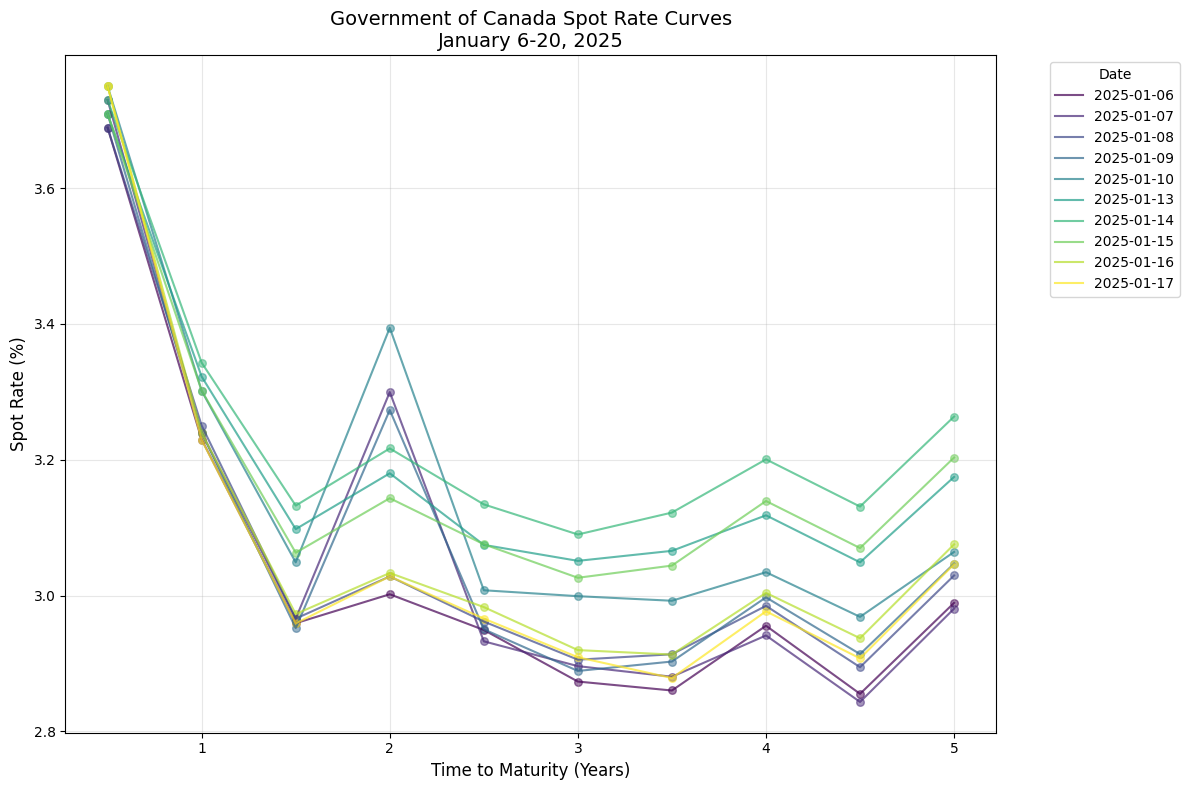

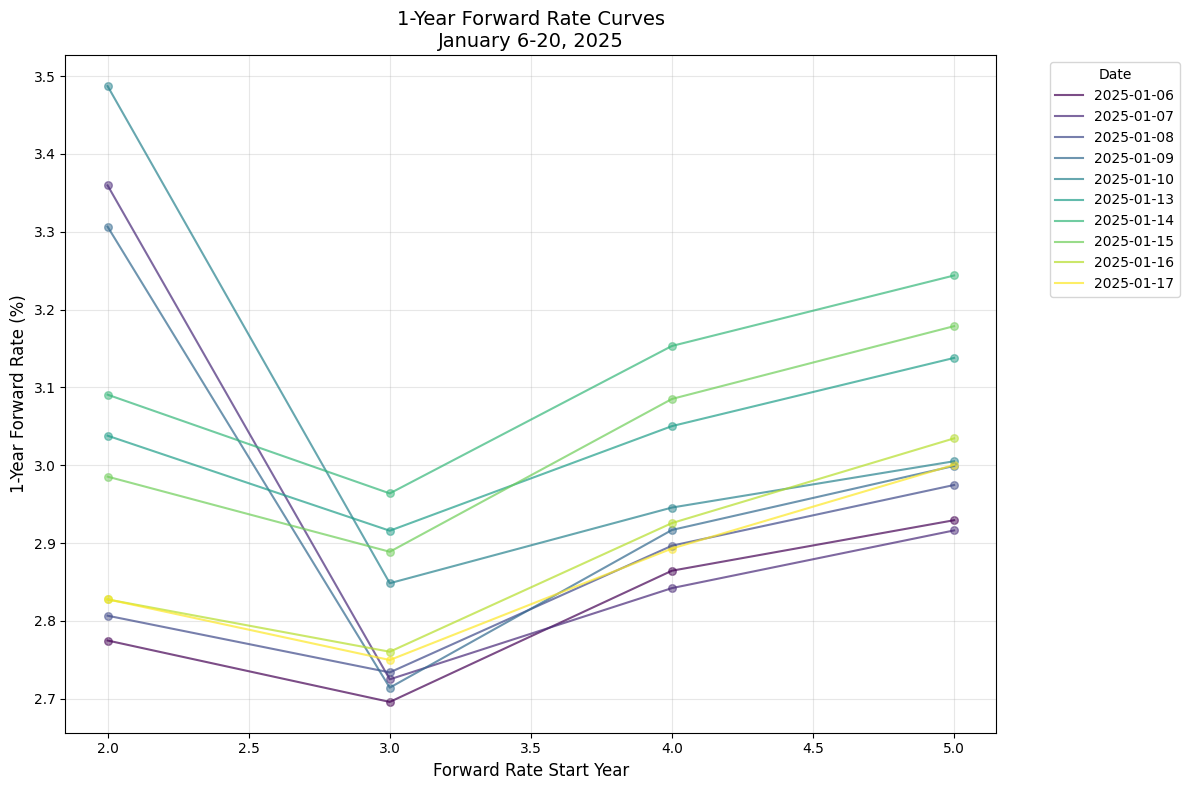

Yield log–returns shape: (9, 5)
Covariance Matrix for Daily Log–Returns of Yields:
                 CAN 3.75 Feb 25  CAN 3.50 Aug 25  CAN 3.00 Apr 26  \
CAN 3.75 Feb 25         0.000084         0.000002         0.000005   
CAN 3.50 Aug 25         0.000002         0.000123         0.000207   
CAN 3.00 Apr 26         0.000005         0.000207         0.000355   
CAN 3.25 Nov 26         0.000410         0.000138         0.000216   
CAN 3.00 Feb 27        -0.000038         0.000184         0.000318   

                 CAN 3.25 Nov 26  CAN 3.00 Feb 27  
CAN 3.75 Feb 25         0.000410        -0.000038  
CAN 3.50 Aug 25         0.000138         0.000184  
CAN 3.00 Apr 26         0.000216         0.000318  
CAN 3.25 Nov 26         0.003618        -0.000025  
CAN 3.00 Feb 27        -0.000025         0.000326  
Forward rate log–returns shape: (9, 4)
Covariance Matrix for Daily Log–Returns of Forward Rates:
          1yr-1yr   1yr-2yr   1yr-3yr   1yr-4yr
1yr-1yr  0.000787  0.000953 -0.001863  

In [51]:

import numpy as np
import matplotlib.pyplot as plt

# Convert daily_spot_curves to correct format
x_values = []
y_values = []
dates = list(daily_spot_curves.keys())

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(dates)))

for date, color in zip(dates, colors):
    curve = daily_spot_curves[date]
    years = np.array([k/2 for k in curve.keys()])  # Convert periods to years
    rates = np.array([v for v in curve.values()]) * 100  # Convert to percentage
    
    plt.plot(years, rates, color=color, alpha=0.7, 
            label=date.strftime('%Y-%m-%d'))
    plt.scatter(years, rates, color=color, alpha=0.5, s=30)

plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Spot Rate (%)', fontsize=12)
plt.title('Government of Canada Spot Rate Curves\nJanuary 6-20, 2025', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Date')
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def calculate_forward_rate(spot_t1, spot_t2, t1, t2):
    """Calculate forward rate using spot rates"""
    return ((1 + spot_t2)**(t2) / (1 + spot_t1)**t1)**(1/(t2-t1)) - 1

def plot_forward_curves(daily_spot_curves):
    plt.figure(figsize=(12, 8))
    dates = list(daily_spot_curves.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(dates)))
    
    for date, color in zip(dates, colors):
        curve = daily_spot_curves[date]
        
        # Calculate 1-year forward rates for years 2-5
        # f(1,2), f(1,3), f(1,4), f(1,5)
        maturities = np.array([2, 3, 4, 5])
        forward_rates = []
        
        # Get spot rate for 1 year
        spot_1yr = curve[2]  # 2 semi-annual periods = 1 year
        
        for t in maturities:
            spot_t = curve[t*2]  # Convert years to semi-annual periods
            fwd_rate = calculate_forward_rate(spot_1yr, spot_t, 1, t)
            forward_rates.append(fwd_rate * 100)  # Convert to percentage
        
        plt.plot(maturities, forward_rates, color=color, alpha=0.7,
                label=date.strftime('%Y-%m-%d'))
        plt.scatter(maturities, forward_rates, color=color, alpha=0.5, s=30)
    
    plt.xlabel('Forward Rate Start Year', fontsize=12)
    plt.ylabel('1-Year Forward Rate (%)', fontsize=12)
    plt.title('1-Year Forward Rate Curves\nJanuary 6-20, 2025', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Date')
    plt.tight_layout()
    plt.show()

# Plot forward curves
plot_forward_curves(daily_spot_curves)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

#################################
# Helper Functions
#################################
def calculate_bond_price(ytm, face_value, coupon_rate, time_to_maturity):
    """
    Calculate the price of a bond with semiannual compounding.
    
    Parameters:
      ytm             : yield-to-maturity (annualized, based on semiannual compounding)
      face_value      : par (face) value of the bond
      coupon_rate     : annual coupon rate (decimal)
      time_to_maturity: time remaining (in years)
    """
    periods = int(np.ceil(time_to_maturity * 2))
    coupon = face_value * coupon_rate / 2
    price = 0.0
    for t in range(1, periods + 1):
        cash_flow = coupon
        if t == periods:
            cash_flow += face_value
        price += cash_flow / ((1 + ytm/2) ** t)
    return price

def calculate_ytm(price, face_value, coupon_rate, time_to_maturity, tol=1e-5):
    """
    Calculate the yield-to-maturity from the bond price.
    
    Returns the yield (in decimal). Uses Newton's method; if it fails, falls back on a grid search.
    """
    def f(y):
        return calculate_bond_price(y, face_value, coupon_rate, time_to_maturity) - price
    
    # A simple initial guess:
    simple_yield = (coupon_rate * face_value + (face_value - price) / time_to_maturity) / price
    try:
        ytm = newton(f, simple_yield, tol=tol, maxiter=100)
    except RuntimeError:
        ys = np.linspace(0.0001, 0.2, 1000)
        fvals = [f(y) for y in ys]
        ytm = ys[np.argmin(np.abs(fvals))]
    return max(ytm, 0)

#################################
# (A) Build Daily Yield Time Series for 5 Bonds
#################################
# We assume:
#   - combined_prices is a DataFrame with dates as index and bond prices as columns.
#   - selected_bonds_df is a DataFrame containing at least the following columns:
#         'Label'         : identifier that matches a column in combined_prices,
#         'Coupon'        : annual coupon rate (in decimal),
#         'Maturity Date' : a pd.Timestamp for the bond's maturity.
#
# To ensure we have exactly 5 bonds (for a 5×5 covariance matrix later), we restrict to the
# first 5 bonds after sorting by maturity.

selected_bonds_df = selected_bonds_df.sort_values('Maturity Date').head(5).reset_index(drop=True)

# Create a DataFrame to store the effective annual yields.
yield_df = pd.DataFrame(index=combined_prices.index)
face = 100  # assume face value is 100

for idx, bond in selected_bonds_df.iterrows():
    label = bond['Label']
    coupon = bond['Coupon']
    maturity = bond['Maturity Date']
    effective_yields = []  # list to hold the yield for each date
    for current_date in combined_prices.index:
        # If the bond has matured, yield is not defined
        if current_date >= maturity:
            effective_yields.append(np.nan)
        else:
            # Time-to-maturity in years
            ttm = (maturity - current_date).days / 365.25
            price = combined_prices.at[current_date, label]
            if pd.isna(price):
                effective_yields.append(np.nan)
            else:
                # Compute the semiannual yield-to-maturity
                ytm = calculate_ytm(price, face, coupon, ttm)
                # Convert to an effective annual yield:
                effective = (1 + ytm/2)**2 - 1
                effective_yields.append(effective)
    yield_df[label] = effective_yields

# Drop dates with any missing yields
yield_df.dropna(inplace=True)

#################################
# (B) Compute Daily Log–Returns for Yields and Their 5×5 Covariance Matrix
#################################
# Compute daily log–returns:
# For each bond, define:
#    X_{i,t} = log( r_{i,t+1} / r_{i,t} )
log_return_yields = np.log(yield_df / yield_df.shift(1)).dropna()

# Check shape: should be (num_dates, 5)
print("Yield log–returns shape:", log_return_yields.shape)

# Compute covariance matrix (5×5)
cov_yields = log_return_yields.cov()
print("Covariance Matrix for Daily Log–Returns of Yields:")
print(cov_yields)

#################################
# (C) Compute Daily Forward Rates from Yields
#################################
# Under the standard stripping formula for annual compounding:
# Given yields S1, S2, S3, S4, S5 (for maturities 1, 2, 3, 4, 5 years),
# we compute the one-year forward rates:
#   f_{1,1} = ( (1+S2)^2 / (1+S1) ) - 1,
#   f_{1,2} = ( (1+S3)^3 / (1+S2)^2 ) - 1,
#   f_{1,3} = ( (1+S4)^4 / (1+S3)^3 ) - 1,
#   f_{1,4} = ( (1+S5)^5 / (1+S4)^4 ) - 1.
#
# (This assumes that the yields from the bonds approximate the corresponding spot rates.)
forward_rates_list = []
for date, row in yield_df.iterrows():
    # Ensure the yields are in increasing order of maturity
    r1, r2, r3, r4, r5 = row
    f_1 = ((1 + r2)**2 / (1 + r1)) - 1
    f_2 = ((1 + r3)**3 / (1 + r2)**2) - 1
    f_3 = ((1 + r4)**4 / (1 + r3)**3) - 1
    f_4 = ((1 + r5)**5 / (1 + r4)**4) - 1
    forward_rates_list.append([f_1, f_2, f_3, f_4])
    
forward_rates_df = pd.DataFrame(forward_rates_list, 
                                index=yield_df.index, 
                                columns=['1yr-1yr', '1yr-2yr', '1yr-3yr', '1yr-4yr'])

#################################
# (D) Compute Daily Log–Returns for Forward Rates and Their 4×4 Covariance Matrix
#################################
log_return_forward = np.log(forward_rates_df / forward_rates_df.shift(1)).dropna()

# Check shape: should be (num_dates, 4)
print("Forward rate log–returns shape:", log_return_forward.shape)

# Compute covariance matrix (4×4)
cov_forward = log_return_forward.cov()
print("Covariance Matrix for Daily Log–Returns of Forward Rates:")
print(cov_forward)

#################################
# (E) Eigen–Decomposition and One–Sentence Interpretation
#################################
# Eigen–decomposition for yield log–returns
eigvals_y, eigvecs_y = np.linalg.eig(cov_yields)
print("\nEigenvalues for Yield Log–Returns:")
print(eigvals_y)
print("Eigenvectors for Yield Log–Returns (columns correspond to eigenvectors):")
print(eigvecs_y)

# Eigen–decomposition for forward rate log–returns
eigvals_f, eigvecs_f = np.linalg.eig(cov_forward)
print("\nEigenvalues for Forward Rate Log–Returns:")
print(eigvals_f)
print("Eigenvectors for Forward Rate Log–Returns (columns correspond to eigenvectors):")
print(eigvecs_f)

# One-sentence explanation:
print("\nExplanation: The largest eigenvalue and its associated eigenvector indicate that most of the variation in the daily log–returns (of yields or forward rates) is explained by a single common factor—typically representing a parallel shift of the curve—with the eigenvector’s components showing the relative sensitivity of each maturity (or forward segment) to that movement.")

